In [4]:
import sys
from pathlib import Path
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
DATA_FOLDER = 'data'
FOOD_HICP_DK='CP0110DKM086NEST.csv'
FOOD_HICP_NL='CP0110NLM086NEST.csv'
ALL_HICP_DK='CP0000DKM086NEST.csv' 
ALL_HICP_NL='CP0000NLM086NEST.csv' 


In [ ]:
# Get current working directory
cwd = Path.cwd()

# Get parent directory
parent_dir = cwd.parent

# Get data directory
data_dir = Path(parent_dir).joinpath(DATA_FOLDER)

# Get DK HCPI data
try:
    food_hicp_dk_df = pl.read_csv(data_dir.joinpath(FOOD_HICP_DK))
    all_hicp_dk_df = pl.read_csv(data_dir.joinpath(ALL_HICP_DK))
    food_hicp_nl_df = pl.read_csv(data_dir.joinpath(FOOD_HICP_NL))
    all_hicp_nl_df = pl.read_csv(data_dir.joinpath(ALL_HICP_NL))
except FileNotFoundError as er:
    print(er)
    sys.exit('Abort')

food_hicp_dk_df = food_hicp_dk_df.with_columns(pl.col("observation_date").str.strptime(pl.Date, format="%Y-%m-%d"))
all_hicp_dk_df = all_hicp_dk_df.with_columns(pl.col("observation_date").str.strptime(pl.Date, format="%Y-%m-%d"))
food_hicp_nl_df = food_hicp_nl_df.with_columns(pl.col("observation_date").str.strptime(pl.Date, format="%Y-%m-%d"))
all_hicp_nl_df = all_hicp_nl_df.with_columns(pl.col("observation_date").str.strptime(pl.Date, format="%Y-%m-%d"))

food_hicp_dk_df

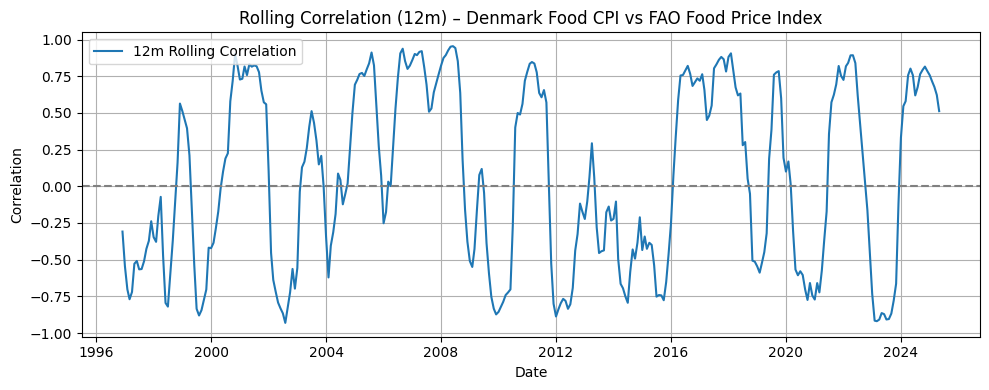

In [6]:
DATA_FOLDER = 'data'
BASE_YEAR = 2015
FOOD_CATEGORIES = ["Food", "Total"]
BENCHMARK_CATEGORIES = ["Brent-Oil", "10-Year TY", "USD/EUR Spot", "Food Price Index"]
HEIGHT = 700
CARD_WIDTH = 220
PLOT_COLORS = {
    ("Denmark", "Total"): "#78a3c5",        
    ("Denmark", "Food"): "#e6a96e",         
    ("Netherlands", "Total"): "#7fb27d",    
    ("Netherlands", "Food"): "#d1797a",     
    ("Global (Oil)", "Brent-Oil"): "#9b7b74",
    ("USA", "10-Year TY"):"#df2795", 
    ("Global (USD/EUR)", "USD/EUR Spot"):"#f1bb1b",
    ("Global (FAO)", "Food Price Index"):"#30f11b",
}

# Get current working directory
cwd = Path.cwd()

# Get parent directory
parent_dir = cwd.parent

# Get data directory
data_dir = Path(parent_dir).joinpath(DATA_FOLDER)

# --- Load & Normalize Data ---
def load_series(file: str, country: str, category: str, need_adj: bool = False):    
    try:
        df = pl.read_csv(data_dir.joinpath(file))
        date_col = df.columns[0] if df.columns[0].lower() in {"date", "observation_date"} else "DATE"
    except FileNotFoundError as er:
        print(er)
        sys.exit('Abort')
    df = (
        df.rename({df.columns[1]: "value"})
        .with_columns(
            pl.col(date_col).str.strptime(pl.Date, "%Y-%m-%d").alias("date"),
            pl.lit(country).alias("country"),
            pl.lit(category).alias("category")
        )
        .select(["date", "country", "category", "value"])
    )
    if need_adj:
        scale_factor = (
            100 / df.filter(pl.col("date").dt.year() == BASE_YEAR)
                    .get_column("value")
                    .median()
        )

        # 2. Apply scaling to all values
        df = df.with_columns(
            (pl.col("value") * scale_factor).round(1).alias("value")
        )
    return df

def load_fao_series(file: str, country: str, category: str, need_adj: bool = True) -> pl.DataFrame:
    try:
        pdf = pd.read_csv(data_dir.joinpath(file), header=2, usecols=range(7))
        df = pl.from_pandas(pdf).filter(pl.col("Date").is_not_null())
    except Exception as e:
        print(f"Failed to load FAO data: {e}")
        sys.exit("Abort")
    a=10
    df = (
        df
        .rename({"Date": "date", "Food Price Index": "value"})
        .with_columns([
            pl.col("date").str.strptime(pl.Date, "%Y-%m"),
            pl.lit(country).alias("country"),
            pl.lit(category).alias("category")
        ])
        .select(["date", "country", "category", "value"])
    )
    if need_adj:
        scale = 100 / df.filter(pl.col("date").dt.year() == BASE_YEAR).get_column("value").median()
        df = df.with_columns((pl.col("value") * scale).round(1).alias("value"))
    return df


df = pl.concat([
    load_series("CP0000DKM086NEST.csv", "Denmark", "Total"),
    load_series("CP0110DKM086NEST.csv", "Denmark", "Food"),
    load_series("CP0000NLM086NEST.csv", "Netherlands", "Total"),
    load_series("CP0110NLM086NEST.csv", "Netherlands", "Food"), 
    load_series("MCOILBRENTEU.csv", "Global (Oil)", "Brent-Oil", need_adj=True),  
    load_series("GS10.csv", "USA", "10-Year TY", need_adj=True),  
    load_series("EXUSEU.csv", "Global (USD/EUR)", "USD/EUR Spot", need_adj=True),  
    load_fao_series("food_price_indices_data_jul25.csv", "Global (FAO)", "Food Price Index", need_adj=True)
])
df = df.with_columns((pl.col("country") + " – " + pl.col("category")).alias("group_key"))
# Filter to relevant indicators
subset = df.filter(pl.col("group_key").is_in(["Denmark – Food", "Global (FAO) – Food Price Index"]))

# Pivot to wide format
wide = (
    subset.select(["date", "group_key", "value"])
          .pivot(values="value", index="date", on="group_key")
          .drop_nulls()
          .sort("date")
          .to_pandas()
)

# Compute 12-month rolling correlation
wide["rolling_corr"] = wide["Denmark – Food"].rolling(12).corr(wide["Global (FAO) – Food Price Index"])

# Plot
plt.figure(figsize=(10, 4))
plt.plot(wide["date"], wide["rolling_corr"], label="12m Rolling Correlation")
plt.axhline(0, color="gray", linestyle="--")
plt.title("Rolling Correlation (12m) – Denmark Food CPI vs FAO Food Price Index")
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()